# Data Generation

## Graph Classes

we use the following graph classes:

- Chemical Graphs (Molecules)
- Random
- Small World
- Scale Free

## Data Save

We save the data as pickle file


In [1]:
import random
import numpy as np
import networkx as nx
from itertools import combinations, groupby


def graph_load_batch(min_num_nodes=20, max_num_nodes=1000, name='ENZYMES', node_attributes=True, graph_labels=True):
    '''
    load many graphs, e.g. enzymes
    :return: a list of graphs
    '''
    print('Loading graph dataset: '+str(name))
    G = nx.Graph()
    # load data
    path = './../data/molecules/'+name+'/'
    data_adj = np.loadtxt(path+name+'_A.txt', delimiter=',').astype(int)
    if node_attributes:
        data_node_att = np.loadtxt(
            path+name+'_node_attributes.txt', delimiter=',')
    data_node_label = np.loadtxt(
        path+name+'_node_labels.txt', delimiter=',').astype(int)
    data_graph_indicator = np.loadtxt(
        path+name+'_graph_indicator.txt', delimiter=',').astype(int)
    if graph_labels:
        data_graph_labels = np.loadtxt(
            path+name+'_graph_labels.txt', delimiter=',').astype(int)

    data_tuple = list(map(tuple, data_adj))

    # add edges
    G.add_edges_from(data_tuple)
    # add node attributes
    for i in range(data_node_label.shape[0]):
        if node_attributes:
            G.add_node(i+1, feature=data_node_att[i])
        G.add_node(i+1, label=data_node_label[i])
    G.remove_nodes_from(list(nx.isolates(G)))

    # split into graphs
    graph_num = data_graph_indicator.max()
    node_list = np.arange(data_graph_indicator.shape[0])+1
    graphs = []
    max_nodes = 0
    for i in range(graph_num):
        # find the nodes for each graph
        nodes = node_list[data_graph_indicator == i+1]
        G_sub = G.subgraph(nodes)
        if graph_labels:
            G_sub.graph['label'] = data_graph_labels[i]
        if G_sub.number_of_nodes() >= min_num_nodes and G_sub.number_of_nodes() <= max_num_nodes:
            graphs.append(G_sub)
            if G_sub.number_of_nodes() > max_nodes:
                max_nodes = G_sub.number_of_nodes()
    print('Loaded')
    return graphs


def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G


def connect_all_components(G):
    complement = list(nx.k_edge_augmentation(G, k=1, partial=True))
    if nx.is_frozen(G):
        G = nx.Graph(G)
    G.add_edges_from(complement)
    assert nx.is_connected(G)


In [2]:
import numpy as np
import networkx as nx
import pickle
from tqdm.notebook import trange, tqdm

dataset = {
    "random": [],
    "smallworld": [],
    "scalefree": [],
    "complete": [],
    "line": [],
    "tree": [],
    "star": [],
}


# generate graphs using networkx and save them in the dataset
print("Generating random, smallworld and scalefree graphs...")
for j in trange(5, desc="Generating a new set of graphs"):
    for i in trange(5, 205):
        # random graph
        G = gnp_random_connected_graph(i, 0.3)
        dataset["random"].append(G)
        # small world graph
        G = nx.connected_watts_strogatz_graph(i, round(i / 2), 0.3)
        dataset["smallworld"].append(G)


for i in trange(2, 202, desc="Generating random trees, star, complete and scalefree graphs"):
    # random tree
    dataset["tree"].append(nx.random_tree(i))
    # star graph
    dataset["star"].append(nx.star_graph(i))
    # complete graphs
    dataset["complete"].append(nx.complete_graph(i))
    # complete graphs
    dataset["line"].append(nx.path_graph(i))
    # scale free graph
    G = nx.barabasi_albert_graph(i, round(i / 2))
    if not nx.is_connected(G):
        print(f"connecting {G}")
        connect_all_components(G)
    dataset["scalefree"].append(G)


for i in trange(2, 11, desc="Generating tree"):
    # tree graphs
    non_isomorphic_trees = nx.nonisomorphic_trees(i)
    dataset["tree"].extend(non_isomorphic_trees)


for key in dataset:
    for (i, G) in tqdm(enumerate(dataset[key]), total=len(dataset[key]), desc=f"Setting Node Label as Attribute for {key}"):
        node_labels = np.arange(G.number_of_nodes())
        degrees = nx.degree_centrality(G)
        density = nx.density(G)
        betweenness = nx.betweenness_centrality(G)
        attrs = dict(zip(node_labels, node_labels))
        nx.set_node_attributes(G, attrs, "label")
        nx.set_node_attributes(G, degrees, "degree")
        nx.set_node_attributes(G, density, "density")
        nx.set_node_attributes(G, betweenness, "betweenness")

# save the dataset
with open("dataset.pickle", "wb") as f:
    pickle.dump(dataset, f)


Generating random, smallworld and scalefree graphs...


Generating a new set of graphs:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Generating random trees, star, complete and scalefree graphs:   0%|          | 0/200 [00:00<?, ?it/s]

Generating tree:   0%|          | 0/9 [00:00<?, ?it/s]

Setting Node Label as Attribute for random:   0%|          | 0/1000 [00:00<?, ?it/s]

Setting Node Label as Attribute for smallworld:   0%|          | 0/1000 [00:00<?, ?it/s]

Setting Node Label as Attribute for scalefree:   0%|          | 0/200 [00:00<?, ?it/s]

Setting Node Label as Attribute for complete:   0%|          | 0/200 [00:00<?, ?it/s]

Setting Node Label as Attribute for line:   0%|          | 0/200 [00:00<?, ?it/s]

Setting Node Label as Attribute for tree:   0%|          | 0/400 [00:00<?, ?it/s]

Setting Node Label as Attribute for star:   0%|          | 0/200 [00:00<?, ?it/s]

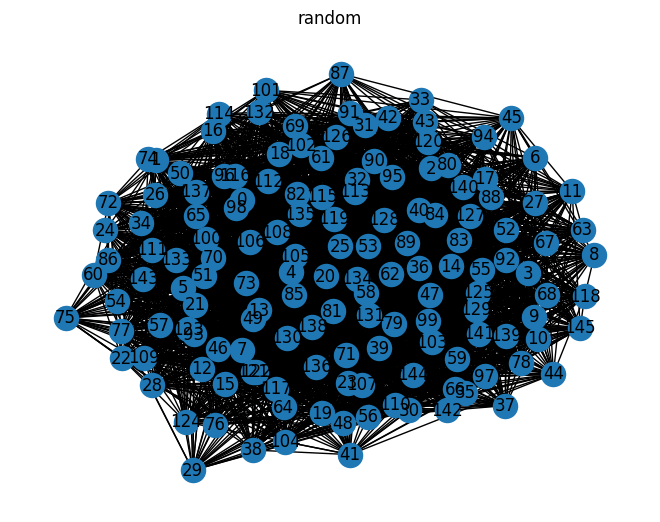

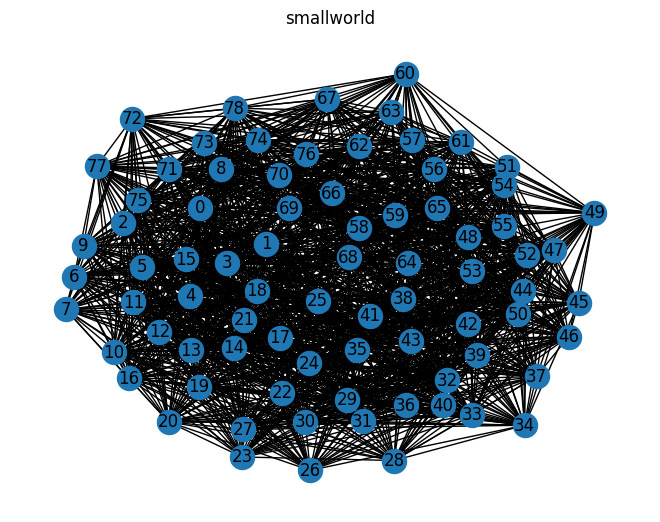

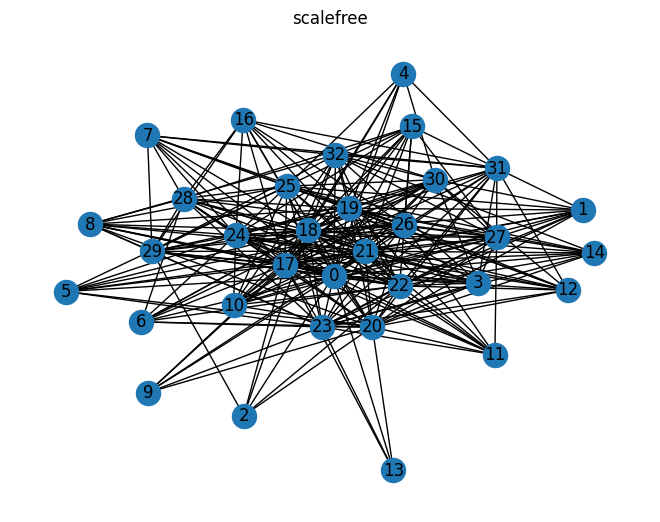

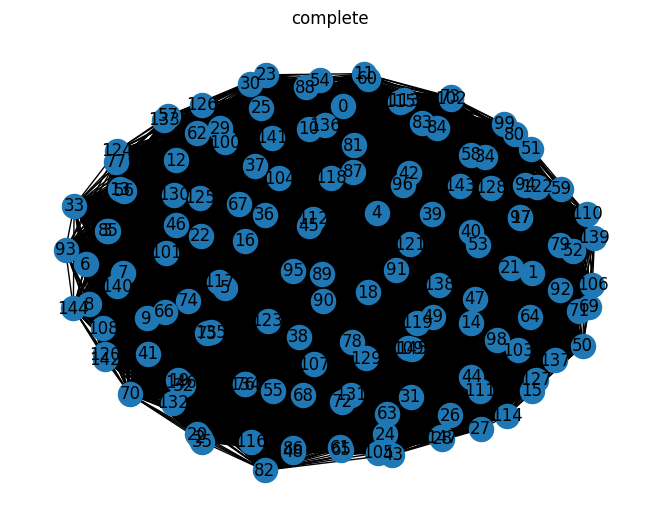

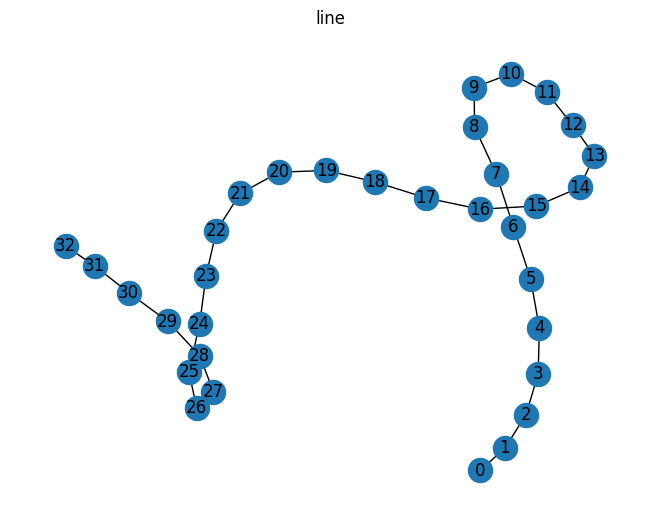

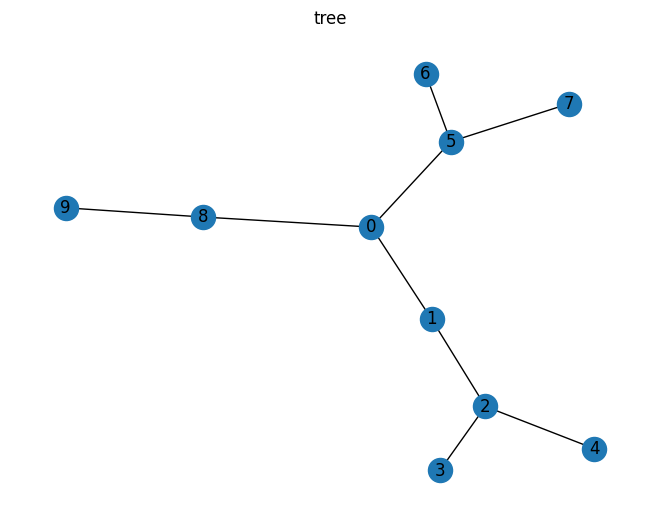

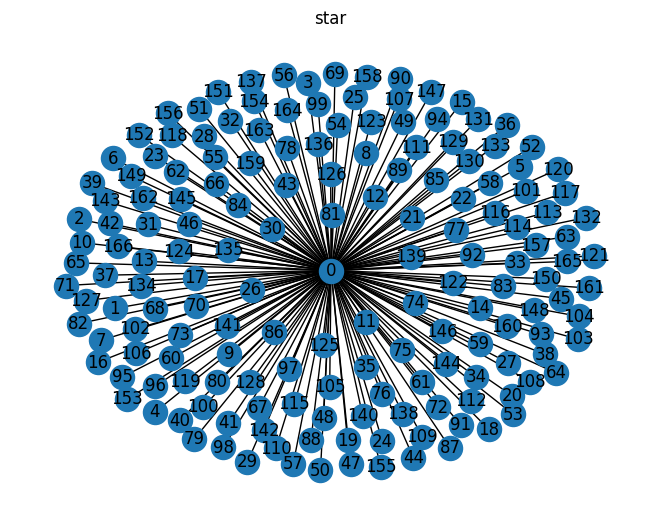

In [3]:
%matplotlib inline

# display the first graph of each type in the dataset
import matplotlib.pyplot as plt
import networkx as nx
import random

for key in dataset:
    G = dataset[key][random.randint(0, len(dataset[key]) - 1)]
    nx.draw(G, with_labels=True)
    plt.title(key)
    plt.show()


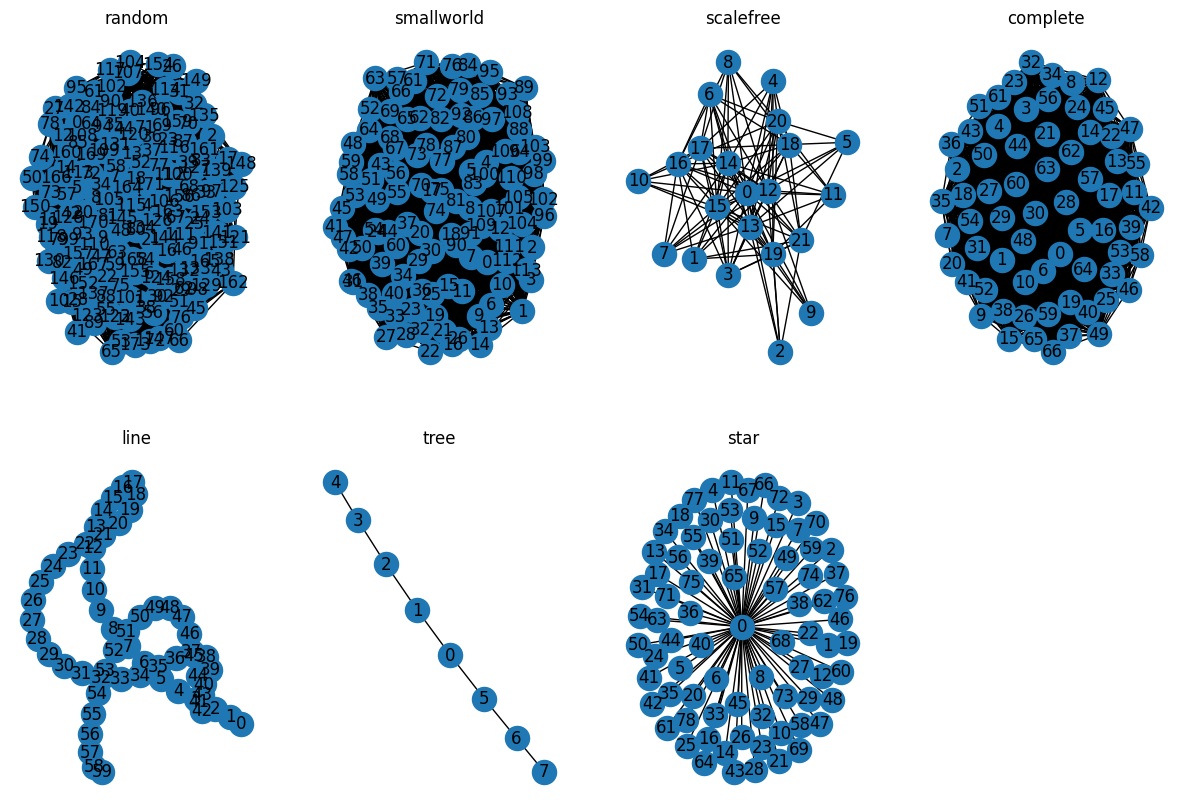

In [4]:
%matplotlib inline

# display the first graph of each type in the dataset
import matplotlib.pyplot as plt
import networkx as nx
import random

# draw a random graph of each type in one figure
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for i, key in enumerate(dataset):
    G = dataset[key][random.randint(0, len(dataset[key]) - 1)]
    ax = axs[i // 4, i % 4]
    nx.draw(G, with_labels=True, ax=ax)
    ax.set_title(key)

fig.delaxes(axs[1, 3])
